# Домашнее задание к занятию 2.1: Деревья решений. Классификация
# HW 1 ML Pikulev Lev

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

### Загрузка данных и первичный взгляд на данные по Титанику

In [521]:
# загрузим библиотеки
import numpy as np
import pandas as pd

In [522]:
# загрузим библиотеки и установим параметры для визуализаций
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

In [523]:
# возьмем исходные данные и определим их как train и test
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [524]:
# смотрим на train
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [525]:
train.info() # есть пропущенные значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [526]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [527]:
# смотрим на test
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [528]:
test.info() # есть пропущенные значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [529]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Создание фичей

1 Склеим оба датасета

2 Из train уберем целевую переменную Survived 

3 Пометим данные из test новым признаком 'is_test'

In [530]:
# выносим целевую переменную в объект Series и пока забываем про него
y_train = train['Survived']
type(y_train)

pandas.core.series.Series

In [531]:
# из train удаляем признак (столбец) 'Survived'
train.drop('Survived', axis=1, inplace=True)

In [532]:
# теперь состав колонок должен совпадать у train и test, проверим:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [533]:
# чтобы опознать потом тестовые и тренировочные данные, пометим их новым признаком
train['is_test'] = 0
test['is_test'] = 1

In [534]:
# склеим два датафрейма
df = pd.concat([train, test])

In [535]:
# взглянем на df 
df.head(10)
# потом после обработки разобъем его по признаку 'is_test'

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0


Признаки Sex, Embarked и Pclass можно заэнкодить, т.к. у них небольшой набор вариантов

In [536]:
df.Sex.value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [537]:
df.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [538]:
df.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [539]:
# для пола обозначим единицами мужчин, нолями женщин и создадим для этого новый столбец
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
# удалим категориальные фичи. PassengerId оставим
df.drop(["Sex", "Cabin", "Ticket", "Name"], axis=1, inplace=True)

In [540]:
# вот что получили
df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked,is_test,isMale
0,1,3,22.0,1,0,7.2500,S,0,1
1,2,1,38.0,1,0,71.2833,C,0,0
2,3,3,26.0,0,0,7.9250,S,0,0
3,4,1,35.0,1,0,53.1000,S,0,0
4,5,3,35.0,0,0,8.0500,S,0,1


In [541]:
# обработаем Pclass и Embarked. Получившийся датафрейм назовемdf_dummies
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

In [542]:
# посмотрим на результат
df_dummies.head()

,PassengerId,Age,SibSp,Parch,Fare,is_test,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,2,38.0,1,0,71.2833,0,0,1,0,0,1,0,0
2,3,26.0,0,0,7.9250,0,0,0,0,1,0,0,1
3,4,35.0,1,0,53.1000,0,0,1,0,0,0,0,1
4,5,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


Вспомним про пропущенные значения

In [543]:
df_dummies.isnull().sum()

PassengerId      0
Age            263
SibSp            0
Parch            0
Fare             1
is_test          0
isMale           0
Pclass_1         0
Pclass_2         0
Pclass_3         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
dtype: int64

Но вначале разделим датафрейм на тренировочный и тестовый, чтобы логика заполнения пустых значений ограничивалась данными в рамках каждого датафрейма

In [544]:
# разделяем по признаку 'is_test' и дропаем сразу его
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [545]:
# смотрим, что получилось
X_train.head(2)

,PassengerId,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,1,0,0,1,0,0,1
1,2,38.0,1,0,71.2833,0,1,0,0,1,0,0


In [546]:
X_test.head(2)

,PassengerId,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892,34.5,0,0,7.8292,1,0,0,1,0,1,0
1,893,47.0,1,0,7.0000,0,0,0,1,0,0,1


Разберемся с пропущенными значениями

In [547]:
from sklearn.preprocessing import Imputer

In [548]:
# пустые значения заполним медианными
imputer = Imputer(missing_values='NaN', strategy='median', axis=0, verbose=0, copy=True)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [549]:
# "обучим" imputer
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [550]:
# создадим "импутированный" массив, где пустые значения заполнены медианными по столбцу
X_train_imputed = imputer.transform(X_train)

In [551]:
# полученный массив превращаем в датафрейм 
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

In [552]:
# смотрим на результат
X_train_imputed.head(6)

,PassengerId,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4.0,35.0,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,6.0,28.0,0.0,0.0,8.4583,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [553]:
# обратим внимание, что у пассажира с индексом 5 не был указан возраст, а теперь ему 28.
X_train.head(6)

,PassengerId,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,1,0,0,1,0,0,1
1,2,38.0,1,0,71.2833,0,1,0,0,1,0,0
2,3,26.0,0,0,7.9250,0,0,0,1,0,0,1
3,4,35.0,1,0,53.1000,0,1,0,0,0,0,1
4,5,35.0,0,0,8.0500,1,0,0,1,0,0,1
5,6,NaN,0,0,8.4583,1,0,0,1,0,1,0


In [554]:
X_train.shape

(891, 12)

In [555]:
y_train.shape

(891,)

Сделаем восстановление пропущенных значений и в X_test

In [556]:
imputer.fit(X_test)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [557]:
X_test_imputed = imputer.transform(X_test)

In [558]:
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_train.columns)

In [559]:
X_test_imputed.head(6)

,PassengerId,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892.0,34.5,0.0,0.0,7.8292,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,893.0,47.0,1.0,0.0,7.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,894.0,62.0,0.0,0.0,9.6875,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,895.0,27.0,0.0,0.0,8.6625,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,896.0,22.0,1.0,1.0,12.2875,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,897.0,14.0,0.0,0.0,9.2250,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [560]:
X_test.shape

(418, 12)

Закончим варить фичи

### Метод главных компонент

In [561]:
# импортируем метод PCA
from sklearn.decomposition import PCA

Text(0,0.5,'explained_variance_ratio_')

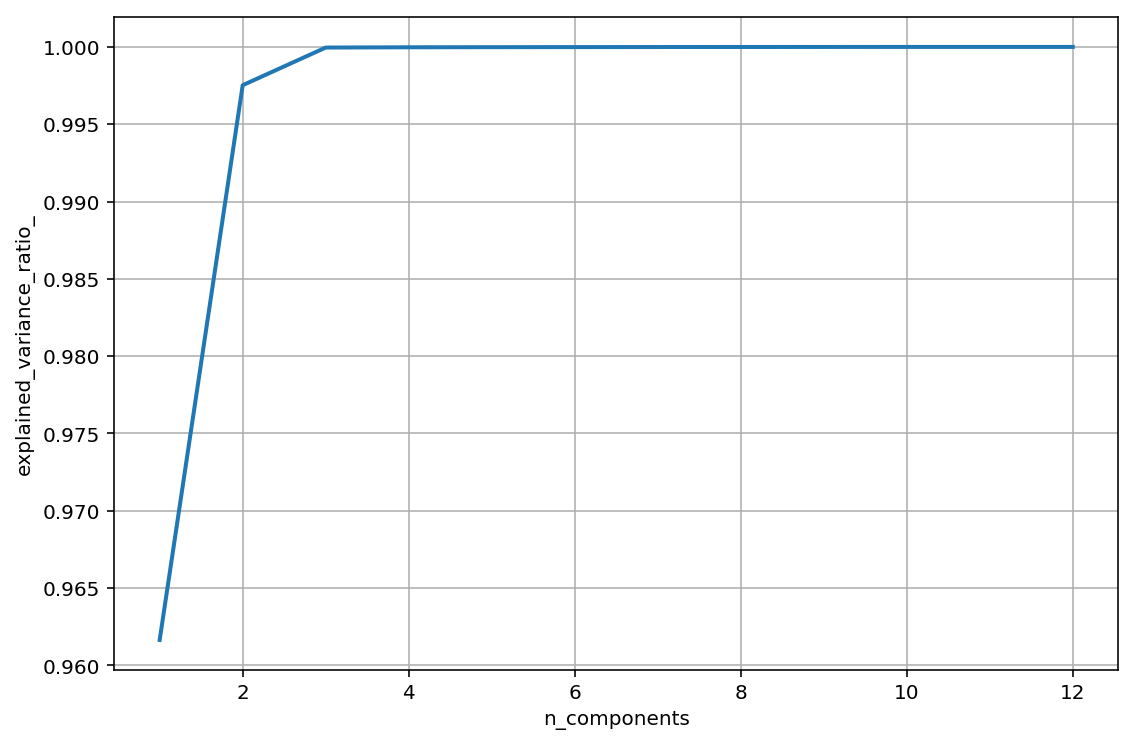

In [562]:
# и ез нормализации данных пытаемся его применить, чтобы увидеть, сколько фичей объясняют какой % дисперсии
pca = PCA().fit(X_train_imputed)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [563]:
# результат не вызывает доверия, нужно отнормировать компоненты

### Нормирование значений

In [564]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Text(0,0.5,'explained_variance_ratio_')

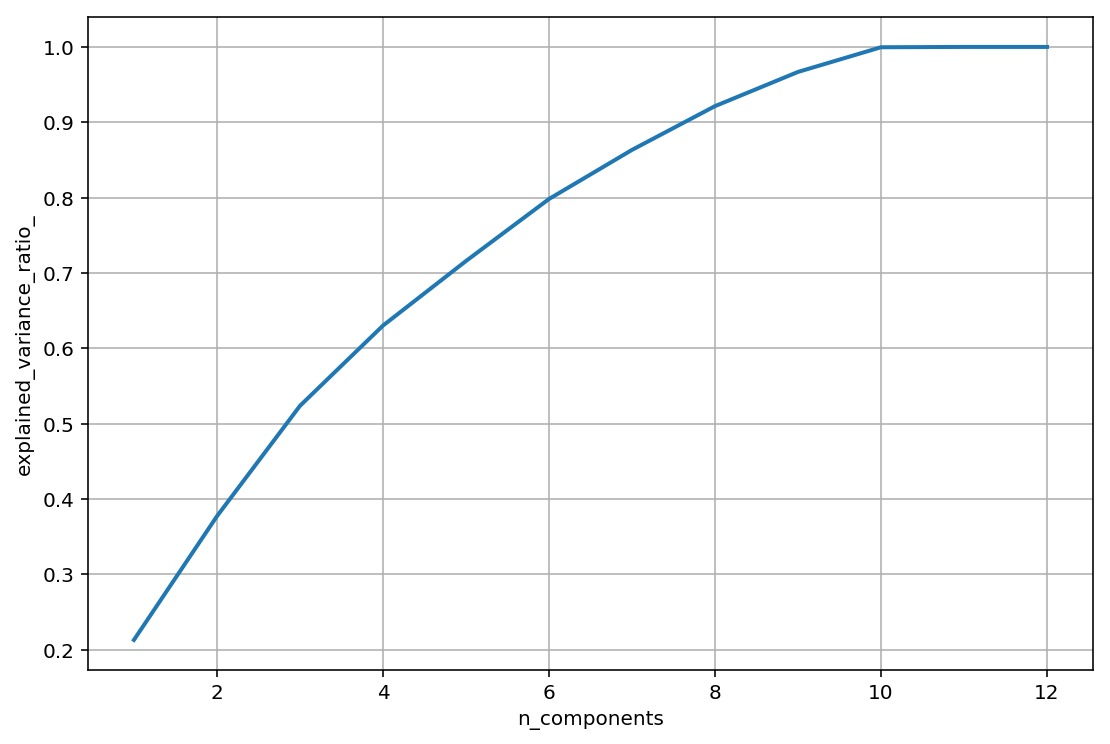

In [565]:
from sklearn.decomposition import PCA
pca = PCA().fit(scaler.fit_transform(X_train_imputed))
# pca = PCA().fit(df_train)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [566]:
# теперь можно сказать, что 7 фичей объясняют 90% дисперсии

In [567]:
np.set_printoptions(precision=3) # выведем три знака после запятой для массива pca.explained_variance_ratio_
pca.explained_variance_ratio_ # Percentage of variance explained by each of the selected components.

array([0.213, 0.164, 0.146, 0.106, 0.086, 0.082, 0.065, 0.058, 0.045,
       0.033, 0.   , 0.   ])

In [568]:
pca.components_[0]

array([ 0.023,  0.227, -0.038,  0.033,  0.457, -0.154,  0.528, -0.023,
       -0.436,  0.391, -0.096, -0.287])

In [569]:
# сортируем по убыванию components_
# Principal axes in feature space, representing the directions of maximum variance in the data. 
# The components are sorted by explained_variance_
sorted(pca.components_[0], reverse=True)

[0.5277315900689852,
 0.4570119011100123,
 0.39099875231213915,
 0.22668673863339145,
 0.032747402198278486,
 0.023434029919193945,
 -0.023432049627360323,
 -0.03791097383011249,
 -0.09635687348561825,
 -0.15359168290963518,
 -0.28656584139485536,
 -0.4356256497595426]

In [570]:
# найдем номера первых трех компонент по степени влияния

In [571]:
np.argmax(pca.components_[0]) # номер компоненты, с влиянием 0.52

6

In [572]:
# X_train_imputed.iloc[:, 5]
#ответ: Name: isMale, Length: 891, dtype: float64

In [573]:
# выведем номера компонент с максимальным влиянием на дисперсию (первые 3)
comps = [] # список, в который положим номера первых трех по значимости компонент
for i in range (0,3):
    print('Номер компоненты с влиянием {0:.3f}: {1}'.
          format(sorted(pca.components_[0], reverse=True)[i], np.argmax(pca.components_[i])))
    comps.append(np.argmax(pca.components_[i]))


Номер компоненты с влиянием 0.528: 6
Номер компоненты с влиянием 0.457: 10
Номер компоненты с влиянием 0.391: 3


In [574]:
# выведем названия компонент с максимальным влиянием на дисперсию (первые 3)

for comp in comps:
    print(X_train_imputed.iloc[:, comp-1].describe())
    print()


count    891.000000
mean       0.647587
std        0.477990
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: isMale, dtype: float64

count    891.000000
mean       0.188552
std        0.391372
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Embarked_C, dtype: float64

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64



In [575]:
# вспомним про нормирование данных методом  scaler

In [576]:
# вот, во что превращает scaler наш датафрейм после нормирования:
pd.DataFrame(scaler.fit_transform(X_train_imputed)).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.730108,-0.565736,0.432793,-0.473674,-0.502445,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
1,-1.726220,0.663861,0.432793,-0.473674,0.786845,-1.355574,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.614710
2,-1.722332,-0.258337,-0.474545,-0.473674,-0.488854,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
3,-1.718444,0.433312,0.432793,-0.473674,0.420730,-1.355574,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
4,-1.714556,0.433312,-0.474545,-0.473674,-0.486337,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306


In [577]:
# для обучения деревьев не будем использовать нормирование, т.к. это необязательно и затруднит интерпретацию результатов

### Разделение на обучающую и тестирующую выборки

In [578]:
# можно было бы разделить X_train_imputed на train, val и test. Но т.к. у нас уже есть изначально train и test, это не требуется
# from sklearn.model_selection import train_test_split
# X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed, y_train, test_size=0.2)

In [579]:
X_train_imputed.head()

,PassengerId,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4.0,35.0,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [580]:
# индекс стал типа float при применении imputer

In [581]:
# вернем, как было
X_test_imputed['PassengerId'] = X_test_imputed['PassengerId'].astype(int)
X_train_imputed['PassengerId'] = X_train_imputed['PassengerId'].astype(int)

In [582]:
# взглянем на значения целевой переменной в тестовых данных. Использовать при обучении не будем!
y_test = pd.read_csv('titanic/gender_submission.csv')
y_test.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [583]:
y_test = y_test.Survived


In [584]:
# проверим размерность тестового и тренировочного датафреймов

print(X_train_imputed.shape)
print(y_train.shape)
print(X_test_imputed.shape)
print(y_test.shape)

(891, 12)
(891,)
(418, 12)
(418,)


### Обучение с кросс-валидацией

In [585]:
# грузим GridSearchCV и DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV # комбинаторный перебор параметров
from sklearn.tree import DecisionTreeClassifier

In [587]:
# попробуем оценить эфективность при разных глубинах деревьев от 1 до 10
depths = np.arange(1,10)
features_num = np.arange(5,11)
#min_samples_leaves = np.arange(1,5)
grid = {'max_depth': depths, 'max_features': features_num}#, 'min_samples_leaf': min_samples_leaves}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)
# говорим возьми DecisionTreeClassifier и для словаря grid (в котором только один ключ max_depth) перебери 10 значений
# отсортируй их по neg_log_loss (scoring='neg_log_loss') на пятикратную кросс-валидацию

In [588]:
%%time
gridsearch.fit(X_train_imputed, y_train) # фитим


Wall time: 1.52 s


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'max_features': array([ 5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [589]:
from sklearn.model_selection import GridSearchCV

In [590]:
# сортируем результат оценки
#sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)
sorted(zip(gridsearch.cv_results_['mean_test_score'], gridsearch.cv_results_['params']), key = lambda x: -x[0])

[(-0.4531297562925494, {'max_depth': 3, 'max_features': 6}),
 (-0.4688830091110508, {'max_depth': 2, 'max_features': 9}),
 (-0.47227694596173886, {'max_depth': 2, 'max_features': 10}),
 (-0.4851157199083382, {'max_depth': 2, 'max_features': 7}),
 (-0.49047038752898525, {'max_depth': 3, 'max_features': 8}),
 (-0.5025926306646545, {'max_depth': 2, 'max_features': 6}),
 (-0.5158788068586676, {'max_depth': 1, 'max_features': 10}),
 (-0.5194320170084741, {'max_depth': 1, 'max_features': 9}),
 (-0.5287256936919075, {'max_depth': 2, 'max_features': 8}),
 (-0.5379665893176709, {'max_depth': 2, 'max_features': 5}),
 (-0.5505164008909708, {'max_depth': 3, 'max_features': 7}),
 (-0.5515061465539707, {'max_depth': 1, 'max_features': 7}),
 (-0.5550593567037772, {'max_depth': 1, 'max_features': 6}),
 (-0.5627408372569411, {'max_depth': 1, 'max_features': 8}),
 (-0.5758448648977097, {'max_depth': 3, 'max_features': 10}),
 (-0.5806988596314759, {'max_depth': 3, 'max_features': 5}),
 (-0.62326417721119

In [591]:
scoring = pd.DataFrame(gridsearch.cv_results_).sort_values(by='mean_test_score', ascending=False)[['params', 'mean_test_score']]
scoring=scoring.reset_index()
del scoring['index']
scoring

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\de

,params,mean_test_score
0,"{'max_depth': 3, 'max_features': 6}",-0.453130
1,"{'max_depth': 2, 'max_features': 9}",-0.468883
2,"{'max_depth': 2, 'max_features': 10}",-0.472277
3,"{'max_depth': 2, 'max_features': 7}",-0.485116
4,"{'max_depth': 3, 'max_features': 8}",-0.490470
5,"{'max_depth': 2, 'max_features': 6}",-0.502593
6,"{'max_depth': 1, 'max_features': 10}",-0.515879
7,"{'max_depth': 1, 'max_features': 9}",-0.519432
8,"{'max_depth': 2, 'max_features': 8}",-0.528726
9,"{'max_depth': 2, 'max_features': 5}",-0.537967


In [592]:
# соберем в списки значения max_depth и max_features, чтобы даьше визуализировать
max_depth_list = []
max_features_list = []
for i in scoring.index:
    max_depth_list.append(int(str(scoring['params'][i]).split(' ')[1][:-1]))
    max_features_list.append(int(str(scoring['params'][i]).split(' ')[3][:-1]))
print(max_depth_list)
print('Длина списка max_depth_list: ', len(max_depth_list))
print(max_features_list)
print('Длина списка max_features_list: ', len(max_features_list))

[3, 2, 2, 2, 3, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 3, 1, 4, 4, 3, 5, 4, 4, 4, 4, 5, 6, 5, 5, 5, 6, 5, 6, 6, 6, 6, 7, 7, 8, 7, 7, 7, 7, 8, 8, 8, 9, 8, 9, 8, 9, 9, 9, 9]
Длина списка max_depth_list:  54
[6, 9, 10, 7, 8, 6, 10, 9, 8, 5, 7, 7, 6, 8, 10, 5, 5, 5, 6, 9, 5, 8, 7, 10, 9, 6, 8, 8, 9, 10, 6, 7, 9, 10, 7, 5, 5, 8, 5, 6, 9, 7, 10, 6, 8, 9, 10, 7, 5, 10, 6, 7, 9, 8]
Длина списка max_features_list:  54


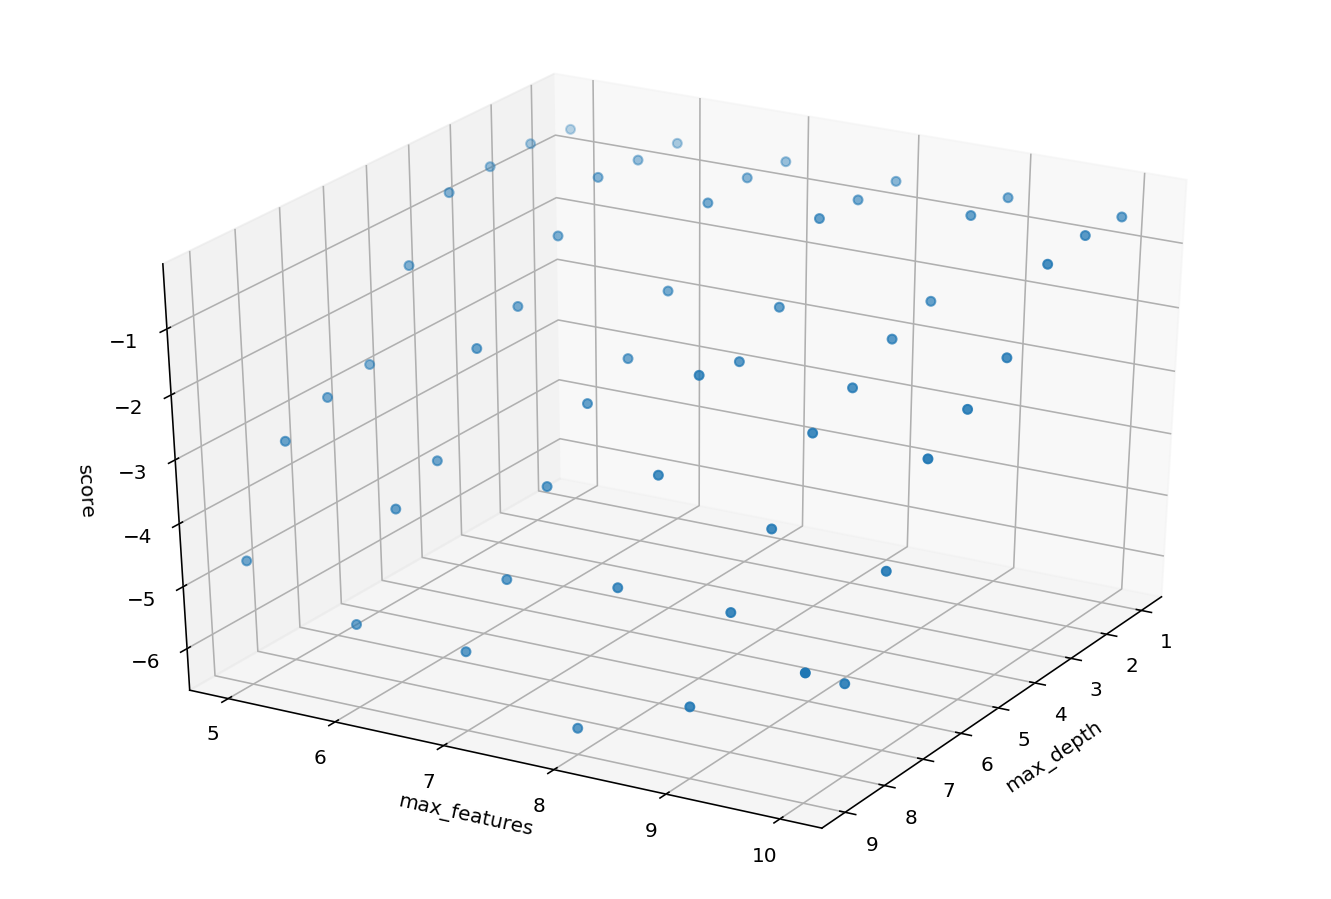

In [593]:
# посмотрим на лучшие варианты
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D
 
fig = pylab.figure()
ax = Axes3D(fig)
 
x = max_depth_list
y = max_features_list
z = list(scoring['mean_test_score'])
 
ax.scatter(x, y, z)
ax.set_xlabel('max_depth')
ax.set_ylabel('max_features')
ax.set_zlabel('score')


ax.view_init(30, 30)
pyplot.show()

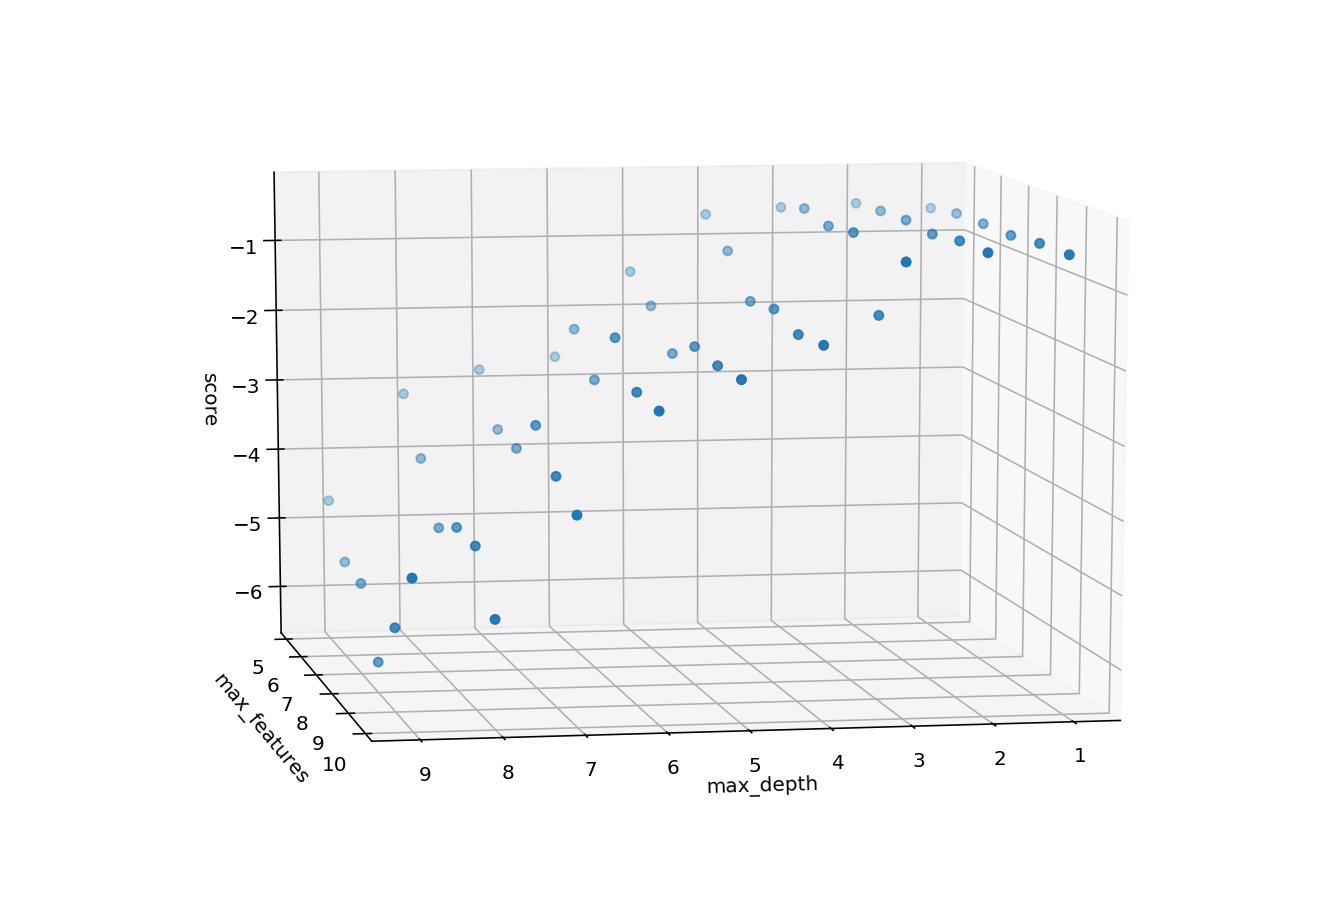

In [594]:
fig = pylab.figure()
ax = Axes3D(fig)
 
x = max_depth_list
y = max_features_list
z = list(scoring['mean_test_score'])
 
ax.scatter(x, y, z)
ax.set_xlabel('max_depth')
ax.set_ylabel('max_features')
ax.set_zlabel('score')

ax.view_init(10, 80)
pyplot.show()

In [595]:
# Лучшие сочетания - это глубина дерева от 1 до 2 (будем брать 2), максимально фичей от 5 до 10 (разница невелика, но возьмем 10)

Фиксируем max_depth=2 , max_features=10

Строим модель

In [596]:
clf_final = DecisionTreeClassifier(max_depth=2, max_features=10)

In [597]:
clf_final.fit(X_train_imputed, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Делаем предсказания на тренировочных данных и оцениваем модель

In [598]:
y_pred_proba = clf_final.predict_proba(X_train_imputed)
y_pred = clf_final.predict(X_train_imputed)

In [599]:
y_pred

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,

In [600]:
y_pred_proba[:5, :]

array([[0.832, 0.168],
       [0.032, 0.968],
       [0.355, 0.645],
       [0.032, 0.968],
       [0.832, 0.168]])

In [601]:
# проверим точность и другие метрики на X_train_imputed (891 строк) и y_train

In [602]:
# измерим точность
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.7957351290684624

In [603]:
# измерим полноту
from sklearn.metrics import recall_score
recall_score(y_train, y_pred)

0.7280701754385965

In [604]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred) 

0.7323529411764705

In [605]:
from sklearn import metrics
metrics.roc_auc_score(y_train, y_pred_proba[:,1])

0.8028552711469019

In [606]:
metrics.average_precision_score(y_train, y_pred_proba[:,1])

0.7102650772213839

In [607]:
metrics.log_loss(y_train, y_pred_proba[:,1])

0.4737445162358296

Делаем предсказания на тестовых данных

In [608]:
X_test_imputed.head()

,PassengerId,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892,34.5,0.0,0.0,7.8292,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,893,47.0,1.0,0.0,7.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,894,62.0,0.0,0.0,9.6875,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,895,27.0,0.0,0.0,8.6625,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,896,22.0,1.0,1.0,12.2875,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [609]:
y_pred_proba = clf_final.predict_proba(X_test_imputed)
y_pred = clf_final.predict(X_test_imputed)

In [610]:
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [611]:
y_pred_proba[:5, :]

array([[0.832, 0.168],
       [0.355, 0.645],
       [0.832, 0.168],
       [0.832, 0.168],
       [0.355, 0.645]])

In [612]:
# измерим точность на тестовых данных
accuracy_score(y_test, y_pred)

0.9808612440191388

In [613]:
# измерим полноту на тестовых данных
recall_score(y_test, y_pred)

1.0

In [614]:
f1_score(y_test, y_pred) 

0.9743589743589743

In [615]:
metrics.roc_auc_score(y_test, y_pred_proba[:,1])

0.9798179659675504

In [616]:
metrics.average_precision_score(y_test, y_pred_proba[:,1])

0.9664473684210526

In [617]:
metrics.log_loss(y_test, y_pred_proba[:,1])

0.24538813888929878

Подготовим сабмит

In [618]:
submit = pd.DataFrame(X_test_imputed['PassengerId'])
submit['Survived'] = y_pred
submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [619]:
# есть сложности с тем, что Excel убивает ведущие нули

In [620]:
# перед охранением в csv переведем предсказание в строчный вид и добавим кавычки
#submit['Survived'] = submit['Survived'].astype(str)
#type(submit['Survived'][0])

In [621]:
#submit['Survived'] = submit['Survived'].apply(lambda x: "'" + str(x) + "'")


In [622]:
#submit.head()

In [517]:
submit.to_csv('submission3.csv', index=False)

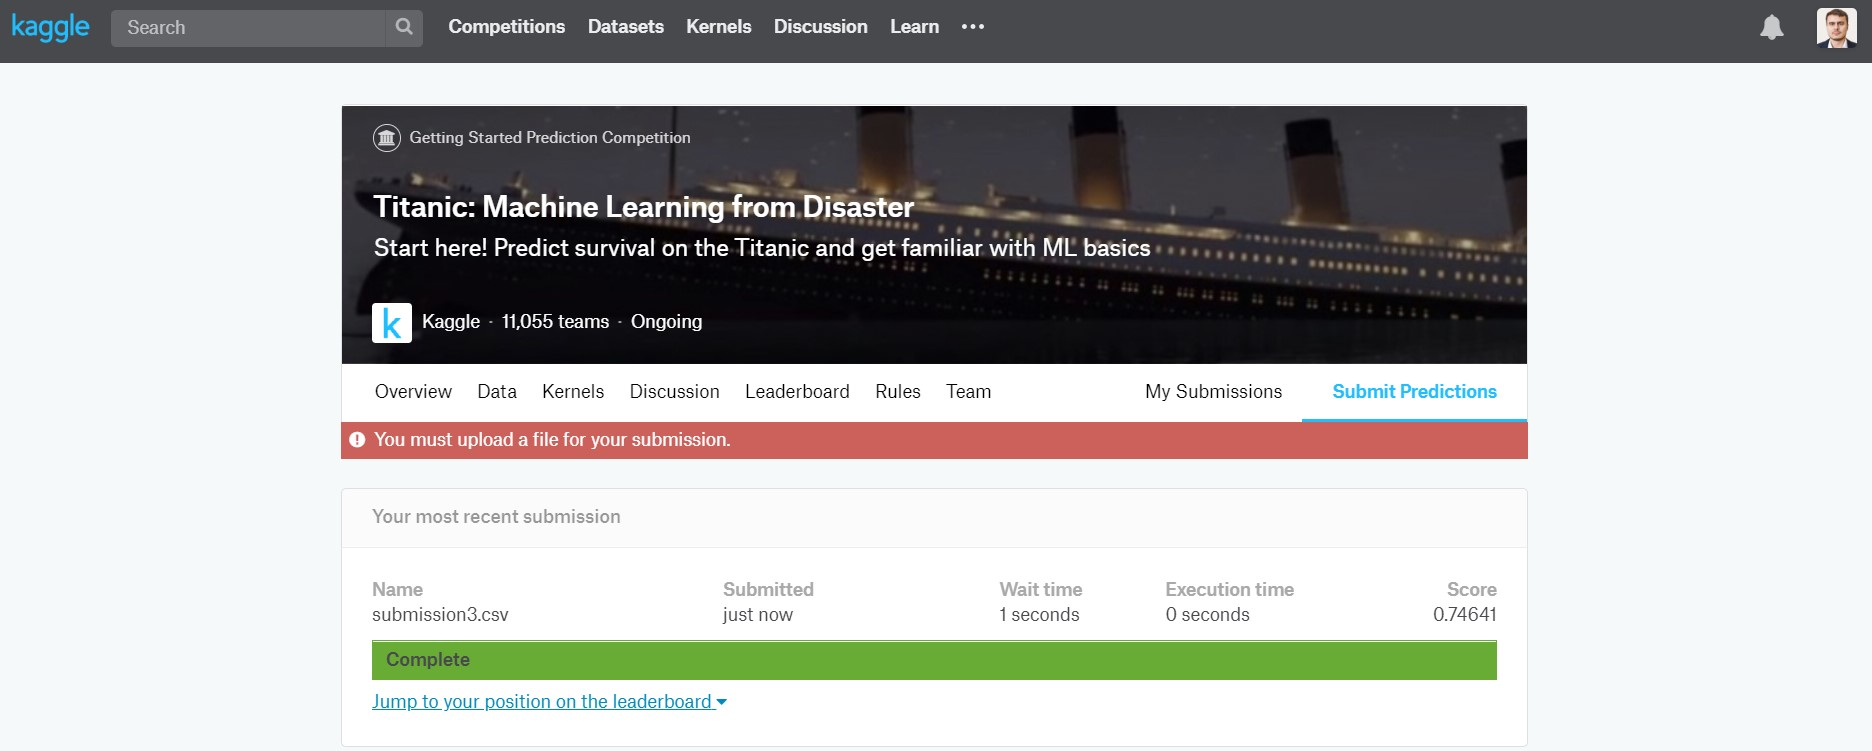

In [623]:
# загрузка на Kaggle
from IPython.display import Image
Image("Screenshot_2.jpg")

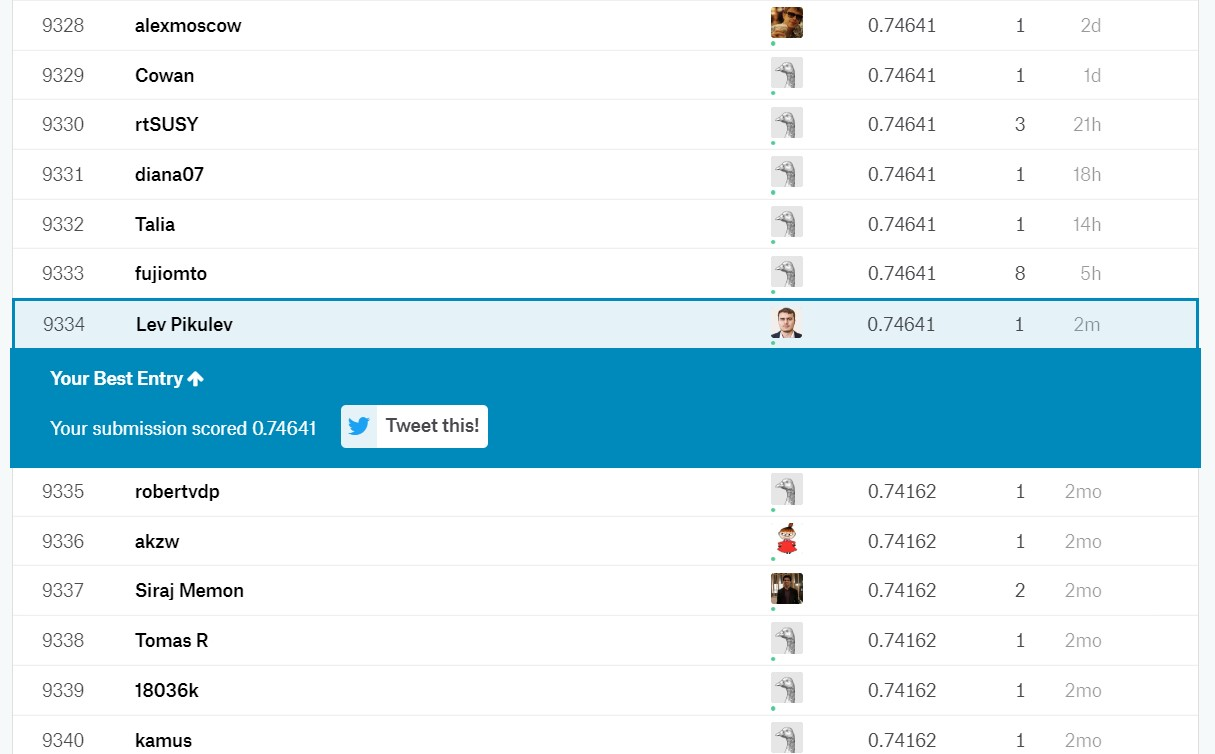

In [624]:
# место в рейтинге...
Image("Screenshot_4.jpg")

Теперь для интерпретируемости дерева заменим 1 и 0 на значения 'resqued' и 'dead'

In [507]:
df = pd.DataFrame(X_test_imputed)
df['Survived'] = y_pred
df.head()

,PassengerId,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Survived
0,892,34.5,0.0,0.0,7.8292,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,893,47.0,1.0,0.0,7.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
2,894,62.0,0.0,0.0,9.6875,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,895,27.0,0.0,0.0,8.6625,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,896,22.0,1.0,1.0,12.2875,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [508]:
from sklearn.preprocessing import LabelEncoder

In [509]:
le = LabelEncoder() # запоминает соответствие текстовых данных и числа
y = le.fit_transform(y_train)

In [510]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [511]:
get_tree_dot_view(clf_final, list(df.columns)[:-1], ['dead', 'resqued'])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="isMale <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = dead", fillcolor="#e5813960"] ;
1 [label="Pclass_3 <= 0.5\ngini = 0.383\nsamples = 314\nvalue = [81, 233]\nclass = resqued", fillcolor="#399de5a6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.1\nsamples = 170\nvalue = [9, 161]\nclass = resqued", fillcolor="#399de5f1"] ;
1 -> 2 ;
3 [label="gini = 0.5\nsamples = 144\nvalue = [72, 72]\nclass = dead", fillcolor="#e5813900"] ;
1 -> 3 ;
4 [label="Age <= 6.5\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = dead", fillcolor="#e58139c4"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.444\nsamples = 24\nvalue = [8, 16]\nclass = resqued", fillcolor="#399de57f"] ;
4 -> 5 ;
6 [label="gini = 0.28\nsamples = 553\nvalue = [460, 93]\nclass = dead", fillcolor="#e58139cb"] ;
4 -> 6 ;
}


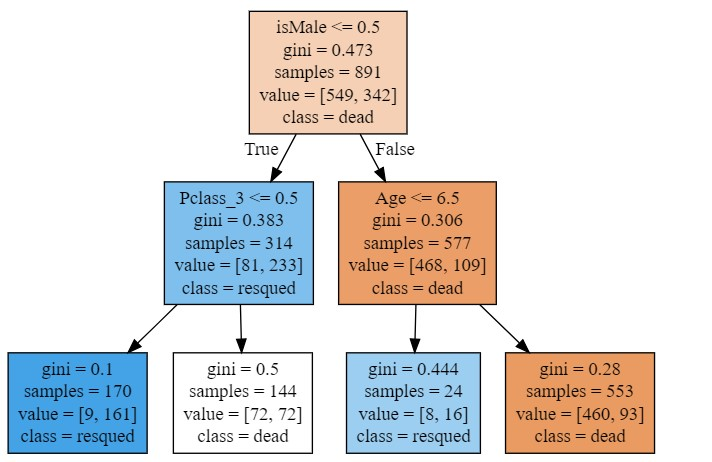

In [515]:
# рисуем дерево на http://www.webgraphviz.com
from IPython.display import Image
Image("tree2.jpg")